# Cluster analysis of SDMoA paintings

## Importing stuff

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from itertools import cycle #for plotting clusters
import seaborn as sns
sns.set()
from sklearn.cluster import AffinityPropagation, KMeans
from sklearn import metrics
from sklearn.manifold import TSNE 
from sklearn import preprocessing

In [33]:
#import matrix of average emotion scores for each painting as a pandas df
aveEmotionsMATLAB = pd.read_csv("aveEmotion.csv");
#aveEmotionsMATLAB.head(5)

In [34]:
#import all rating data
ratingData = np.empty((109, 9, 22))

for i in range(1,22):
    ratingData[:,:,i-1] = pd.read_excel("ratingData-sorted.xlsx", sheet_name=i, usecols=range(4,13))

In [35]:
ratingData[:,0,0]

array([4., 2., 3., 4., 2., 4., 3., 4., 4., 4., 4., 5., 4., 4., 4., 5., 3.,
       4., 4., 3., 4., 4., 6., 4., 5., 3., 4., 5., 4., 4., 4., 4., 4., 5.,
       4., 4., 5., 4., 5., 6., 4., 5., 4., 4., 4., 4., 4., 5., 5., 4., 5.,
       4., 4., 1., 4., 4., 3., 4., 1., 2., 4., 4., 1., 4., 4., 5., 3., 4.,
       4., 2., 5., 2., 1., 4., 2., 3., 3., 2., 1., 4., 4., 2., 4., 3., 4.,
       7., 5., 4., 2., 3., 5., 3., 2., 4., 4., 4., 5., 5., 4., 3., 4., 4.,
       5., 1., 5., 4., 4., 4., 4.])

## An exploration in normalization...

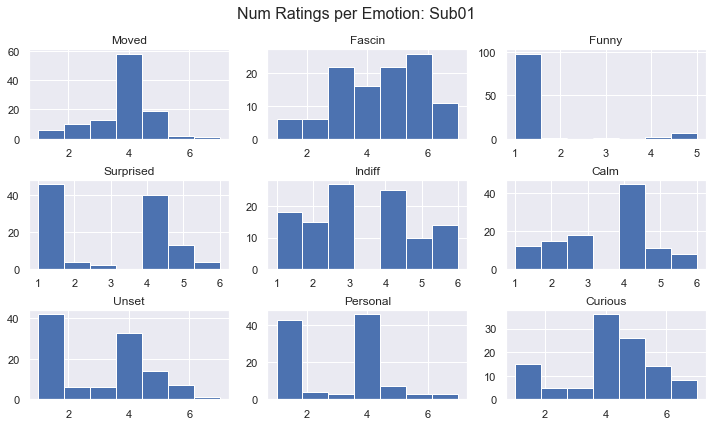

In [36]:
#histograms of scores for each emotion for sub01 (pre-normalizing)

fig, axes = plt.subplots(nrows=3, ncols=3, sharey = True, sharex = True, figsize=(10,6))

#plt.setp(axes, xticks=[1,2,3,4,5,6,7]) 
emotionList=["Moved","Fascin","Funny","Surprised","Indiff","Calm","Unset","Personal","Curious"]
fig.suptitle("Num Ratings per Emotion: Sub01", size=16)

dim=331
for i in range(0,9):
    plt.subplot(dim+i)
    plt.hist(ratingData[:,i,0], bins=7)
    plt.title(emotionList[i])
    #I can't get the labels below to work :(
    plt.ylabel=("Num Times Used")
    plt.xlabel=("Score")
    plt.xticks=([1,2,3,4,5,6,7])
                  
plt.tight_layout()
fig.subplots_adjust(top=0.88)

/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


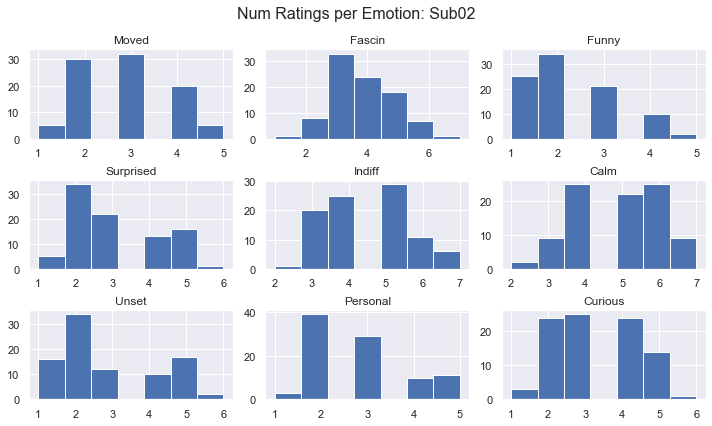

In [37]:
#histogram of average Moved score for sub02

fig, axes = plt.subplots(nrows=3, ncols=3, sharey = True, sharex = True, figsize=(10,6))

emotionList=["Moved","Fascin","Funny","Surprised","Indiff","Calm","Unset","Personal","Curious"]
fig.suptitle("Num Ratings per Emotion: Sub02", size=16)

dim=331
for i in range(0,9):
    plt.subplot(dim+i)
    plt.hist(ratingData[:,i,1], bins=7)
    plt.title(emotionList[i])
    
plt.tight_layout()
fig.subplots_adjust(top=0.88)

Different emotions have really different distributions, even within a subject, so I definitely agree that we should standardize per subject & emotion rather than just subject.

In [38]:
#standardize data per person per emotion (find mean, find sd, substract mean and divide by sd)
standardRating = np.copy(ratingData)

for i in range(0,20): #per subject
    for j in range(0,9): #per emotion
        standardRating[:,j,i] = preprocessing.scale(ratingData[:,j,i])

In [39]:
#just making sure this^ did something
print(ratingData[0,:,0])
print(standardRating[0,:,0])

[4. 5. 1. 1. 4. 5. 1. 5. 2.]
[ 0.20438319  0.3        -0.3202773  -1.08274325  0.42862642  1.12656998
 -1.10861485  1.20744681 -1.28173825]


I also tried computing this without using the preprocessing module, just to double check it was doing the same thing and indeed it was! But there was an error: RuntimeWarning: invalid value encountered in double_scalars so I'm using the preprocessing. This was the other version:  

In [40]:
#standardRatingByHand = np.copy(ratingData)

#for i in range(0,20):
    #for j in range(0,9):
        #mean = np.nanmean(standardRatingByHand[:,j,i])
        #sd = np.nanstd(standardRatingByHand[:,j,i])
        #for k in range(0,109):
            #standardRatingByHand[k,j,i] = (standardRatingByHand[k,j,i]-mean)/sd

# np.allclose(standardRating,standardRatingByHand, equal_nan=True) --> this outputs True

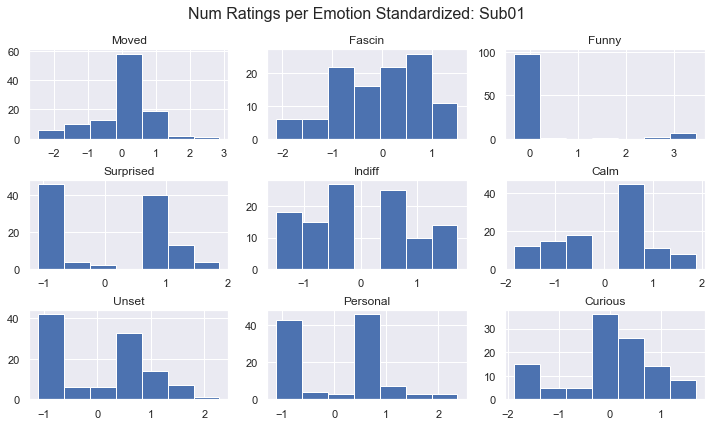

In [41]:
#histogram of average scores for each emotin for sub01 - post-standarizing
fig, axes = plt.subplots(nrows=3, ncols=3, sharey = True, sharex = True, figsize=(10,6))

emotionList=["Moved","Fascin","Funny","Surprised","Indiff","Calm","Unset","Personal","Curious"]
fig.suptitle("Num Ratings per Emotion Standardized: Sub01", size=16)

dim=331
for i in range(0,9):
    plt.subplot(dim+i)
    plt.hist(standardRating[:,i,0], bins=7)
    plt.title(emotionList[i])
    
plt.tight_layout()
fig.subplots_adjust(top=0.88)

### Looks like this didn't change the distribution at all? Might be a visualization issue on my end though. I was having trouble with this graphs >:(

In [ ]:
#This is what I did before - can ignore
#standardRating = ratingData

#for i in range(0,20):
    #standardRating[:,:,i] = preprocessing.scale(ratingData[:,:,i], axis=1)
    
#print(standardRating[:,:,20])

Recreating the matrix of averages

In [42]:
# means of each painting's emotion
aveEmotions = np.zeros((109, 9))

for i in range(0,109):
    for j in range(0,9):
        aveEmotions[i,j] = np.nanmean(standardRating[i,j,:])

In [43]:
# turing aveEmotions into a df
aECols = ['Moved','Fascinated','Funny','Surprised','Indifferent','Calm','Unsettling','Personal','Curious']
aveEmotions = pd.DataFrame(data=aveEmotions, columns=aECols)
aveEmotions

,Moved,Fascinated,Funny,Surprised,Indifferent,Calm,Unsettling,Personal,Curious
0,0.052948,0.515257,-0.061949,0.343406,0.020333,0.288399,-0.050869,0.504495,0.465360
1,-0.162089,-0.097752,0.892742,0.283459,0.493657,0.725983,-0.315574,0.144315,-0.115573
2,0.105169,0.050240,-0.105608,0.120037,0.279688,0.535425,-0.113935,0.506185,0.072750
3,0.645373,0.349044,-0.340119,-0.132023,-0.285472,1.222171,-0.567659,0.425207,0.360446
4,-0.781837,0.213400,1.414844,0.598315,0.509202,-0.067457,0.313044,-0.342069,0.369989
...,...,...,...,...,...,...,...,...,...
104,0.364861,0.439279,-0.207625,-0.113410,0.008220,0.859322,-0.418308,0.146712,-0.127747
105,-0.025683,0.113739,-0.227366,0.068336,0.199605,0.690907,-0.597329,-0.214889,0.182715
106,-0.007388,0.423589,0.060393,0.339530,0.083892,-0.069129,-0.021437,-0.011720,0.292374
107,0.328916,0.656130,-0.113644,0.651156,-0.008252,-0.007733,0.652741,0.007668,0.920673


### Variability

In [44]:
# create matrix of variance scores for each painting
# not using this for anything - just wanted to see what it looked like. Overall, pretty uniform, with a few exceptions.
varsPerPainting = np.zeros(109)

for i in range(0,109):
    varsPerPainting[i] = np.nanvar(standardRating[i,:,:])
    
varsPerPainting = pd.DataFrame(data=varsPerPainting, columns=['Universal Var'])
varsPerPainting

,Universal Var
0,1.627182
1,1.635005
2,1.247571
3,1.407124
4,1.875062
...,...
104,1.228259
105,1.183498
106,1.338202
107,1.433947


In [45]:
#create matrix of variance scores for each emotional dimension per painting
varsPerEmotion = np.zeros((109, 9))

for i in range(0,109):
    for j in range(0,9):
        varsPerEmotion[i, j] = np.nanvar(standardRating[i,j,:])
        
varCols = ['Moved Var','Fascin Var','Funny Var','Surp Var','Indiff Var','Unset Var','Calm Var','Personal Var','Curious Var']
varsPerEmotion = pd.DataFrame(data=varsPerEmotion, columns=varCols)
#adding the total variance because I can
varsPerEmotion = varsPerEmotion.join(varsPerPainting)
varsPerEmotion.head()

,Moved Var,Fascin Var,Funny Var,Surp Var,Indiff Var,Unset Var,Calm Var,Personal Var,Curious Var,Universal Var
0,1.402452,2.594781,0.414478,2.244391,1.072652,2.493314,0.521169,1.132376,2.301219,1.627182
1,1.041327,1.153518,1.068320,1.478257,2.608002,3.217754,0.897394,0.943694,0.869026,1.635005
2,0.723233,0.741389,0.350844,0.658238,2.981981,2.980680,0.963371,0.491628,0.891826,1.247571
3,1.040199,1.778051,0.455414,0.648358,1.348398,1.731478,0.512913,1.102897,1.484159,1.407124
4,0.700985,2.646657,1.233351,1.797966,1.055493,2.410857,0.682448,0.891930,2.363616,1.875062


In [47]:
#create aveEmotions copy without ID column to be used for clustering

#<--don't think we need this anymore cuz it's already an np array now
#X = np.delete(X, 0, axis=1) 
X = aveEmotions.to_numpy()
#X = np.delete(aveEmotions, 0, axis=1) # <-- can't remember what this does but it was there last time so.....
#print(X[:10]) # first ten rows

In [48]:
X[0] # single row (scores for single painting)

array([ 0.05294824,  0.51525699, -0.06194887,  0.34340578,  0.02033313,
        0.28839851, -0.05086927,  0.50449509,  0.46536046])

### Dimensional Reduction (t-SNE)

So we can plot our 9-dim data in 2-d.

Sydney: I set perplexity to 20, which is kind of an arbitrary number, since I think that's around the average number of paintings in each gallery....

See Notes on t-SNE: [https://distill.pub/2016/misread-tsne/](https://distill.pub/2016/misread-tsne/)

In [49]:
# choice of perplexity is subjective, until you see a good layout/separation
# tsne = TSNE(n_components=2, perplexity = 20, random_state = 0) 

tsne = TSNE(n_components=2, perplexity = 30, random_state = 0) 

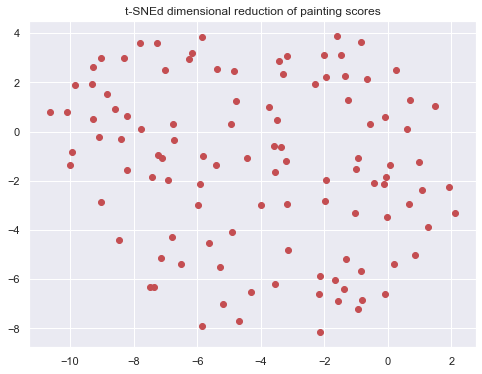

In [50]:
# tSNE performed on aveEmotions data

X_tsned = tsne.fit_transform(X)

plt.figure(figsize=(8, 6))
tsned = plt.scatter(X_tsned[:,0],X_tsned[:,1],c='r')
plt.title('t-SNEd dimensional reduction of painting scores')
plt.show()

## Clustering time!

### Clustering After t-SNE (this is what I originally had, and where the graphs I sent came from)

In [51]:
# clustering
af = AffinityPropagation()

#Cluster! That! Data!
clustering = af.fit(X_tsned) 

cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

In [52]:
# 8 clusters this time!

print(cluster_centers_indices)
print(labels)
print(n_clusters_)

[ 8 24 27 55 60 63 91 92 95]
[0 4 7 8 6 1 8 4 0 0 5 7 6 6 6 2 6 4 7 6 6 5 2 3 1 4 2 2 2 6 1 4 4 4 1 2 3
 6 3 0 1 2 5 4 0 2 3 3 1 1 1 2 4 1 1 3 3 0 6 5 4 4 1 5 8 1 1 7 6 4 2 7 3 0
 1 2 2 7 0 0 3 3 5 8 4 0 7 2 6 5 0 6 7 8 7 8 0 0 7 5 5 7 7 8 7 5 3 2 0]
9


In [54]:
#adding labels to a new aveEmotions df
aveEmotions['ClusterAfter'] = list(labels)
aveEmotions['ClusterBefore'] = np.nan 
aveEmotions['ClusterKMeans'] = np.nan #this is empty for now so certain functions Work
aveEmotions.head(5)

,Moved,Fascinated,Funny,Surprised,Indifferent,Calm,Unsettling,Personal,Curious,ClusterAfter,ClusterBefore,ClusterKMeans
0,0.052948,0.515257,-0.061949,0.343406,0.020333,0.288399,-0.050869,0.504495,0.465360,0,NaN,NaN
1,-0.162089,-0.097752,0.892742,0.283459,0.493657,0.725983,-0.315574,0.144315,-0.115573,4,NaN,NaN
2,0.105169,0.050240,-0.105608,0.120037,0.279688,0.535425,-0.113935,0.506185,0.072750,7,NaN,NaN
3,0.645373,0.349044,-0.340119,-0.132023,-0.285472,1.222171,-0.567659,0.425207,0.360446,8,NaN,NaN
4,-0.781837,0.213400,1.414844,0.598315,0.509202,-0.067457,0.313044,-0.342069,0.369989,6,NaN,NaN


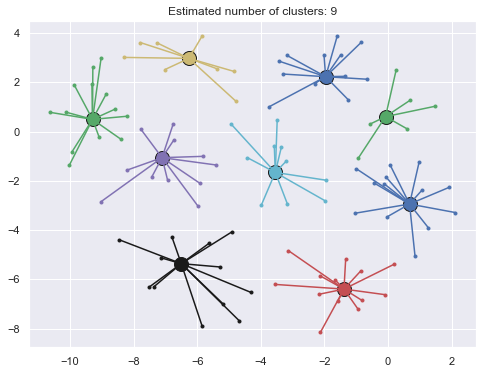

In [55]:
# from sklearn's demo of affinity propogation

plt.close('all')
plt.figure(figsize=(8, 6))
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X_tsned[cluster_centers_indices[k]]
    plt.plot(X_tsned[class_members, 0], X_tsned[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, 
             markeredgecolor='k', markersize=14)
    for x in X_tsned[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [56]:
# function to get a table of the amount of paintings in each cluster

#whichCluster is a string
def amountInCluster(whichCluster,numClusters):
    clusterList = list(range(0,numClusters,1))
    clusterAmount = list(range(0,numClusters,1))

    for i in range(0,numClusters):
        clusterAmount[i] = aveEmotions[whichCluster][(aveEmotions[whichCluster] == i)].count()
    
    clusterDict = {'Cluster': clusterList, 'numItems': clusterAmount}
    clusterAmounts = pd.DataFrame.from_dict(clusterDict)
    
    return clusterAmounts

In [57]:
clusterCountAfter = amountInCluster('ClusterAfter',n_clusters_)
clusterCountAfter

,Cluster,numItems
0,0,14
1,1,14
2,2,14
3,3,11
4,4,13
5,5,10
6,6,13
7,7,13
8,8,7


In [58]:
# function to get col means for each cluster

#whichCluster is a str
def addColAverage(whichCluster,clusterNum):  
    cluster = aveEmotions[(aveEmotions[whichCluster] == clusterNum)] #grabs paintings in a cluster
    means = cluster.mean() #col means
    means = means.drop(labels = ["ClusterAfter","ClusterBefore","ClusterKMeans"]) #drop Cluster labels
    means = means.to_numpy() #converts series to numpy array
    
    return means

In [59]:
#this will be the x vals for plotting
ratings = np.array([1,2,3,4,5,6,7,8,9])

#this checks to make sure addColAverage works
print(type(addColAverage("ClusterAfter",0)))

<class 'numpy.ndarray'>


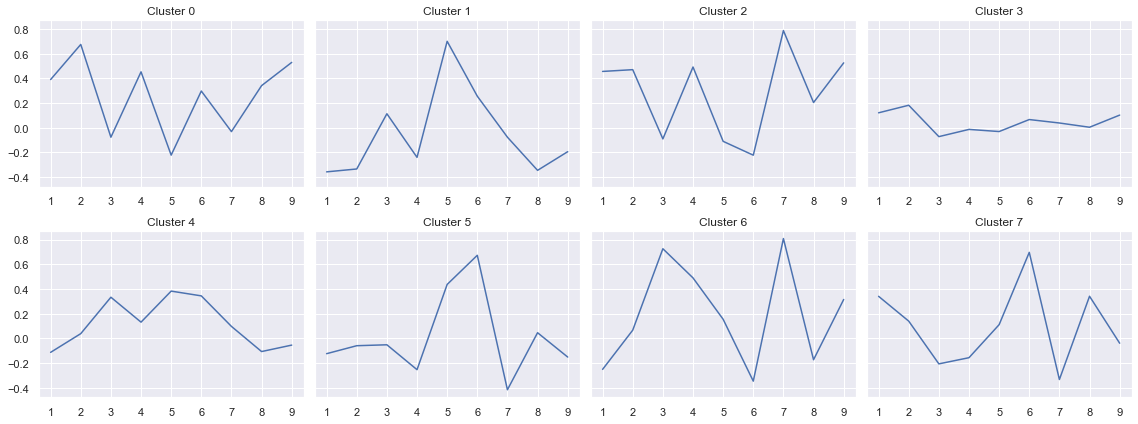

In [60]:
# plot the emotion averages of each cluster

fig, axes= plt.subplots(nrows=2, ncols=4, sharey = True, figsize=(16,6))

plt.setp(axes, xticks=[1,2,3,4,5,6,7,8,9]) #, xticklabels=["Moved","Fascin","Funny","Surprised",
                                                        #"Indiff","Calm","Unset","Personal","Curious"]) #adds tick marks for each emotion category
k = 0
for i in range(0,2):
    for j in range(0,4):
        axes[i,j].plot(ratings, addColAverage("ClusterAfter",k))
        axes[i,j].set_title('Cluster {number}'.format(number = k))
        k = k+1

plt.tight_layout()

plt.show()


### Clustering Before t-SNE

In [61]:
#fitting X (9-dim) instead of transformed X_tsned
clustering2 = af.fit(X) 
                             
cluster_centers_indices2 = af.cluster_centers_indices_
labels2 = af.labels_
n_clusters_2 = len(cluster_centers_indices2)

aveEmotions['ClusterBefore'] = labels2

In [62]:
aveEmotions.head(5)

,Moved,Fascinated,Funny,Surprised,Indifferent,Calm,Unsettling,Personal,Curious,ClusterAfter,ClusterBefore,ClusterKMeans
0,0.052948,0.515257,-0.061949,0.343406,0.020333,0.288399,-0.050869,0.504495,0.465360,0,9,NaN
1,-0.162089,-0.097752,0.892742,0.283459,0.493657,0.725983,-0.315574,0.144315,-0.115573,4,5,NaN
2,0.105169,0.050240,-0.105608,0.120037,0.279688,0.535425,-0.113935,0.506185,0.072750,7,8,NaN
3,0.645373,0.349044,-0.340119,-0.132023,-0.285472,1.222171,-0.567659,0.425207,0.360446,8,8,NaN
4,-0.781837,0.213400,1.414844,0.598315,0.509202,-0.067457,0.313044,-0.342069,0.369989,6,7,NaN


In [63]:
#only 10 clusters this time!

print(cluster_centers_indices2)
print(labels2)
print(n_clusters_2)

[20 27 31 54 58 59 62 91 92 96]
[9 5 8 8 7 3 9 2 9 9 5 8 7 0 7 1 7 2 8 7 0 3 1 2 6 6 1 1 1 7 3 2 2 2 6 1 2
 7 9 9 6 1 2 2 9 1 9 2 3 3 3 1 2 6 3 2 2 9 4 5 2 6 6 5 9 3 6 8 0 2 1 8 8 9
 3 1 1 2 9 9 2 2 3 9 2 1 8 1 7 5 9 7 8 9 8 8 9 9 8 5 5 8 8 9 8 5 9 1 9]
10


I'm not sure I'm doing what you want me to do here...I'm trying to use the transformed data (which should be the same as it was above) to plot the clusters you get when considering all 9 dimensions. The cluster look a little weird, though.

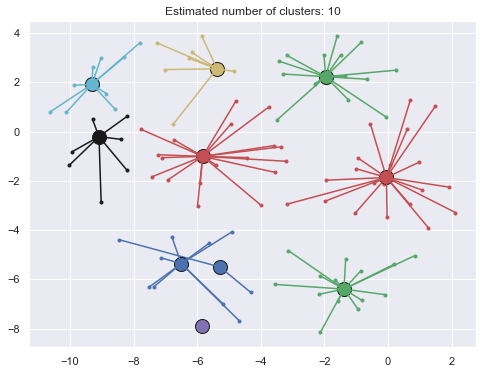

In [64]:
# using X_tsned (transformed data) instead of X

plt.close('all')
plt.figure(figsize=(8, 6))
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_2), colors):
    class_members = labels2 == k
    cluster_center = X_tsned[cluster_centers_indices2[k]]
    plt.plot(X_tsned[class_members, 0], X_tsned[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in X_tsned[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_2)
plt.show()

#fig.savefig('cluster-graph.png') <--this......does not work :( i can't figure out where to place "fig" w/o ruining the graph

In [65]:
clusterCountBefore = amountInCluster('ClusterBefore',n_clusters_2)
clusterCountBefore

,Cluster,numItems
0,0,3
1,1,15
2,2,19
3,3,10
4,4,1
5,5,8
6,6,8
7,7,9
8,8,15
9,9,21


In [66]:
#plt.plot(ratings, np.array(addColAverage("ClusterBefore",0)))
print(addColAverage("ClusterBefore",0))

[-0.12653779 -0.19785847  0.15015125  0.26540092  0.27822    -0.47369007
  1.21774969 -0.18799515  0.24368241]


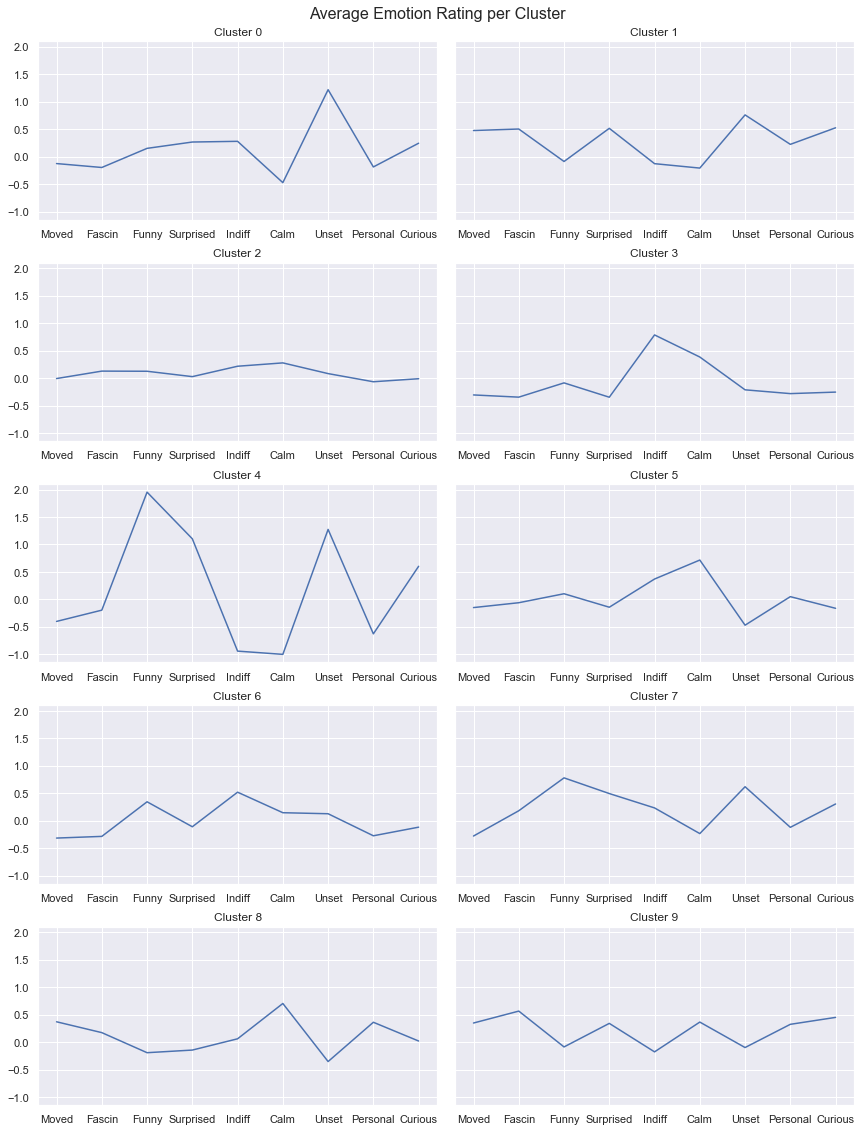

In [67]:
# plot the emotion averages of each cluster

fig, axes= plt.subplots(nrows=5, ncols=2, sharey = True, figsize=(12,16))

plt.setp(axes, xticks=[1,2,3,4,5,6,7,8,9], xticklabels=["Moved","Fascin","Funny","Surprised",
                                                        "Indiff","Calm","Unset","Personal","Curious"]) #adds tick marks for each emotion category
fig.suptitle("Average Emotion Rating per Cluster", size=16)

k = 0
for i in range(0,5):
    for j in range(0,2):
        axes[i,j].plot(ratings, addColAverage("ClusterBefore",k))
        axes[i,j].set_title('Cluster {number}'.format(number = k))
        k = k+1

plt.tight_layout()
fig.subplots_adjust(top=0.95)

plt.show()

#fig.savefig('cluster-averages-linegraph.png')

I'm putting all the stuff I had here about combining clusters in another document - I don't think we'll need it anymore haha.

### Clustering Before t-SNE (KMeans)

In [68]:
#fitting X (9-dim) instead of transformed X_tsned
n_clusters_km = 13
km = KMeans(n_clusters=n_clusters_km)

clusteringkm = km.fit(X) 
                             
labelskm = km.labels_

aveEmotions['ClusterKMeans'] = labelskm

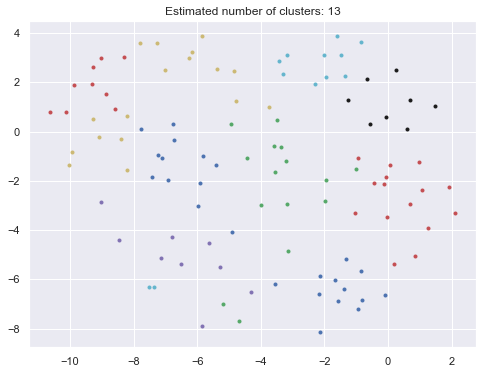

In [69]:
# using X_tsned (transformed data) instead of X

plt.close('all')
plt.figure(figsize=(8, 6))
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_km), colors):
    class_members = labelskm == k
    plt.plot(X_tsned[class_members, 0], X_tsned[class_members, 1], col + '.')

plt.title('Estimated number of clusters: %d' % n_clusters_km)
plt.show()

# Combining everything together!

In [70]:
## importing all rating data to recover painting names/galleries
names = pd.read_excel('ratingData-sorted.xlsx')
names = names.drop(columns = ['a. Moved','b. Fascinated','c. Funny','d. Surprised','e. Indifferent',
                              'f. Calm','g. Unsettling','h. Personal','i. Curious'])
names.rename(columns = {"Unique ID":"ID"}, inplace = True)
names

,Title,Artist,Gallery,ID
0,Untitled (Woman in a Red Dress),Moses Soyer,1,1024
1,Composition,Irene Rice Pereira,1,1018
2,Make Up Girl,Wayne Thiebaud,1,1023
3,Composition with Boats,Stuart Davis,1,1005
4,Untitled,Janet Sobel,1,1014
...,...,...,...,...
104,Mother and Child,Van Gogh,200,20005
105,The Molo...,Bellotto,200,20006
106,Saint Nicholas of Bari,Giovanni Bonsi,16,1605
107,Christ Served by Angels,Juan de Pareja,16,1615


In [71]:
#everything at once
labeledRatings = names.join(aveEmotions)
labeledRatings = labeledRatings.drop(['ClusterAfter', 'ClusterKMeans'], axis=1)
labeledRatings = labeledRatings.join(varsPerEmotion)
labeledRatings.head()

,Title,Artist,Gallery,ID,Moved,Fascinated,Funny,Surprised,Indifferent,Calm,...,Moved Var,Fascin Var,Funny Var,Surp Var,Indiff Var,Unset Var,Calm Var,Personal Var,Curious Var,Universal Var
0,Untitled (Woman in a Red Dress),Moses Soyer,1,1024,0.052948,0.515257,-0.061949,0.343406,0.020333,0.288399,...,1.402452,2.594781,0.414478,2.244391,1.072652,2.493314,0.521169,1.132376,2.301219,1.627182
1,Composition,Irene Rice Pereira,1,1018,-0.162089,-0.097752,0.892742,0.283459,0.493657,0.725983,...,1.041327,1.153518,1.068320,1.478257,2.608002,3.217754,0.897394,0.943694,0.869026,1.635005
2,Make Up Girl,Wayne Thiebaud,1,1023,0.105169,0.050240,-0.105608,0.120037,0.279688,0.535425,...,0.723233,0.741389,0.350844,0.658238,2.981981,2.980680,0.963371,0.491628,0.891826,1.247571
3,Composition with Boats,Stuart Davis,1,1005,0.645373,0.349044,-0.340119,-0.132023,-0.285472,1.222171,...,1.040199,1.778051,0.455414,0.648358,1.348398,1.731478,0.512913,1.102897,1.484159,1.407124
4,Untitled,Janet Sobel,1,1014,-0.781837,0.213400,1.414844,0.598315,0.509202,-0.067457,...,0.700985,2.646657,1.233351,1.797966,1.055493,2.410857,0.682448,0.891930,2.363616,1.875062


In [72]:
#given a cluster, creates a list of the number of paintings in each gallery
galleries = [1,2,3,100,16,19,200]

def numInGallery(clusterNum):

    numIn = np.zeros(7)
    
    sampleCluster = labeledRatings.ClusterBefore == clusterNum
    
    for i in range(0,7):
        sampleGal = labeledRatings.Gallery==galleries[i]
        numIn[i]= len(labeledRatings[sampleCluster & sampleGal])
    
    numIn = list(numIn)
    
    return numIn

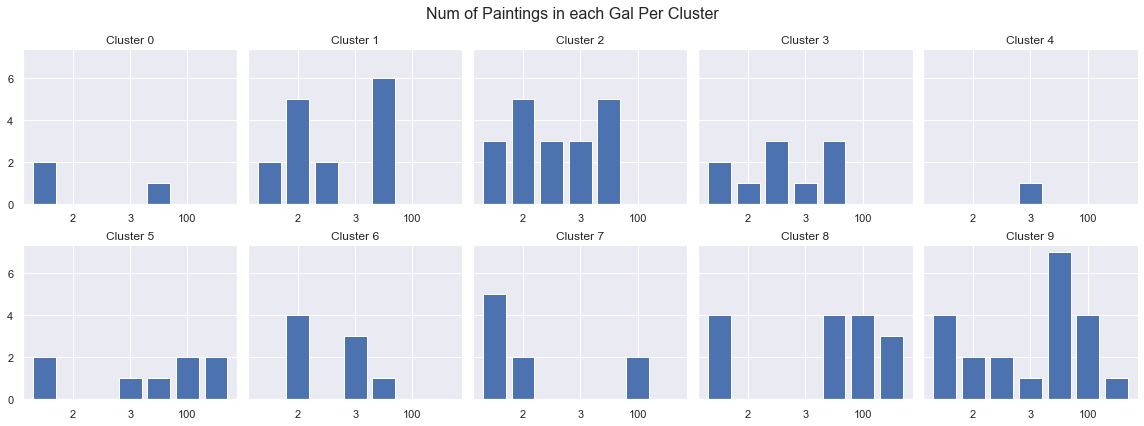

In [76]:
# for each cluster, plot num paintings in each gallery 

fig, axes= plt.subplots(nrows=2, ncols=5, sharey = True, figsize=(16,6))  #[1,2,3,100,16,19,200]

#plt.setp(axes, xticks=[1,2,3,3,4,5,6,7]) #, yticks=[1,2,3,4,5,6,7,8]) #, xticklabels=["Moved","Fascin","Funny","Surprised",
                                                        #"Indiff","Calm","Unset","Personal","Curious"]) #adds tick marks for each emotion category
fig.suptitle("Num of Paintings in each Gal Per Cluster", size=16)
numGals = [1,2,3,4,5,6,7]

k = 0
for i in range(0,2):
    for j in range(0,5):
        if k<n_clusters_2:
            axes[i,j].bar(numGals, numInGallery(k))
            axes[i,j].set_title('Cluster {number}'.format(number = k))
            axes[i,j].set_xticklabels(galleries) # <--I can't get all of these labels to show up :(
            k = k+1

plt.tight_layout()
fig.subplots_adjust(top=0.88)
fig.savefig('num-paintings-in-gal.png')

plt.show()

In [ ]:
# Highest Scores

#most moving
#print(labeledRatings.iloc[(labeledRatings['Moved'].idxmax())])

#most fascinating
#print(labeledRatings.iloc[(labeledRatings['Fascinated'].idxmax())])

#most funny
#print(labeledRatings.iloc[(labeledRatings['Funny'].idxmax())])

#most surprised
#print(labeledRatings.iloc[(labeledRatings['Surprised'].idxmax())])

#most indifferent
#print(labeledRatings.iloc[(labeledRatings['Indifferent'].idxmax())])

#most calm
#print(labeledRatings.iloc[(labeledRatings['Calm'].idxmax())])

#most unsettling
#print(labeledRatings.iloc[(labeledRatings['Unsettling'].idxmax())])

#most personal
#print(labeledRatings.iloc[(labeledRatings['Personal'].idxmax())])

#most curious
#print(labeledRatings.iloc[(labeledRatings['Curious'].idxmax())])

In [77]:
#create 2 dfs: variability, ave score, and diff. sort on diff

#Fascination
fascination = labeledRatings.loc[:,['Title','Artist','Gallery','ID','Fascinated', 'Fascin Var']]
fascination['Diff'] = fascination['Fascinated'] - fascination['Fascin Var']
fascination = fascination.sort_values(by=['Diff'], ascending=False)

#Indifference
indiff = labeledRatings.loc[:,['Title','Artist','Gallery','ID','Indifferent', 'Indiff Var']]
indiff['Diff'] = indiff['Indifferent'] - indiff['Indiff Var']
indiff = indiff.sort_values(by=['Indifferent'], ascending=False) ##sorting by rating

#Unsettling
unsettled = labeledRatings.loc[:,['Title','Artist','Gallery','ID','Unsettling', 'Unset Var']]
unsettled['Diff'] = unsettled['Unsettling'] - unsettled['Unset Var']
unsettled = unsettled.sort_values(by=['Unsettling'], ascending=False) ##sorting by rating

In [81]:
#unsettled & Indifferent --> top 20 that have variance less than 2

#labeledRatings[(labeledRatings['ClusterBefore'] == 4)]
unsettledSmall = unsettled[(unsettled['Unset Var']<2)]
unsettledSmall = unsettledSmall.head(n=20)

indiffSmall = indiff[(indiff['Indiff Var']<2)]
indiffSmall = indiffSmall.head(n=20)

fascinationSmall = fascination.head(n=20)

In [82]:
unsettledSmall

,Title,Artist,Gallery,ID,Unsettling,Unset Var,Diff
68,The Vision of Saint Anthony of Padua,Giovanni Battista Pittoni,16,1617,1.661434,1.293201,0.368233
51,Still-life,José Agustín Arrieta,3,3001,1.530336,1.082415,0.447920
58,Torrey Pines,Fechin,100,10010,1.274155,0.801596,0.472559
29,Woman Reading,Eastman Johnson,2,2009,1.250790,1.440417,-0.189626
22,"The Chase Homestead, Shinnecock, Long Island",William Merritt Chase,1,1004,1.056657,1.714801,-0.658144
13,Girl in White Dress (Sara Mazo),Yasuo Kuniyoshi,1,1015,1.020913,1.350308,-0.329395
20,The Edge of the Forest,Theodore Robinson,1,1011,0.970902,1.530546,-0.559644
41,View of the Wetterhorn from Valley of Grindelwald,Albert Bierstadt,2,2001,0.885263,1.131222,-0.245960
12,Mrs. Walter H. Richter,George Wesley Bellows,1,1021,0.863489,1.716433,-0.852944
76,Madonna and Child with the Young Saint John th...,Giuliano Burgiardini,16,1607,0.764169,1.443369,-0.679200


In [85]:
#['Title','Artist','Gallery','ID']
paintingList = pd.concat([fascinationSmall, unsettledSmall, indiffSmall], sort=False)
paintingList.to_excel('paintingList.xlsx')